In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Load data from web

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
col = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
df = pd.read_csv(url, names=col, na_values="?",sep=" ", comment="\t", skipinitialspace=True) 

In [3]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Preprocessing & Feature engineering

### Making Model year into buckets to simplify training process
- **range    : label**
- -inf to 73 : 0
- 73 to 76 : 1
- 76 to 79 : 2
- 79 to inf: 3

    - If **right=True**, then **year 79** belongs to **label 3** else label 2
    - i.e (-inf,73), [73,76), [76,79), [79,inf)
    - else (-inf,73], (73,76], (76,79], (79,inf)

In [4]:
v = torch.from_numpy(df['Model Year'].values)
boundary = torch.tensor([73, 76, 79])
df['Model Year Bucket'] = torch.bucketize(v,
                                         boundary,
                                         right=True)
df.drop(columns=['Model Year'], inplace=True)

### Categorize Origin
- Either use **one-hot** - can lead to curse of dimensionality if more # of classes. Other variants exist like one hot hash encoding.
- or embedding layer(if u have # of large class)

In [5]:
df = pd.get_dummies(df,columns=['Origin'])

In [6]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year Bucket,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,0,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,0,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,0,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,0,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,0,1,0,0


### Filling missing values in Horsepower
- Omitted as there is only 6 such values, but there exists a linear relation as below

Text(0, 0.5, '$Horse Power$')

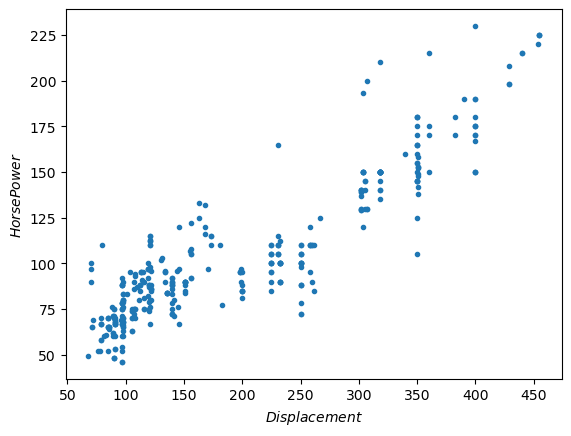

In [7]:
plt.plot(df['Displacement'], df['Horsepower'], marker=".", linestyle="")
plt.xlabel("$Displacement$")
plt.ylabel("$Horse Power$")

In [8]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MPG                392 non-null    float64
 1   Cylinders          392 non-null    int64  
 2   Displacement       392 non-null    float64
 3   Horsepower         392 non-null    float64
 4   Weight             392 non-null    float64
 5   Acceleration       392 non-null    float64
 6   Model Year Bucket  392 non-null    int64  
 7   Origin_1           392 non-null    uint8  
 8   Origin_2           392 non-null    uint8  
 9   Origin_3           392 non-null    uint8  
dtypes: float64(5), int64(2), uint8(3)
memory usage: 25.6 KB


### Convert all to float32 datatype for PyTorch training

In [9]:
df = df[df.columns].astype('float32')

### Standardise the non categorical values

In [10]:
continuous_col = ['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration']
for col in continuous_col:
    df[col] = (df[col] - df[col].mean())/df[col].std()

In [11]:
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year Bucket,Origin_1,Origin_2,Origin_3
393,27.0,-0.862911,-0.519972,-0.479835,-0.220843,0.021267,3.0,1.0,0.0,0.0
394,44.0,-0.862911,-0.930889,-1.363154,-0.997859,3.283479,3.0,0.0,1.0,0.0
395,32.0,-0.862911,-0.567753,-0.531795,-0.803605,-1.428605,3.0,1.0,0.0,0.0
396,28.0,-0.862911,-0.711097,-0.661695,-0.415097,1.108671,3.0,1.0,0.0,0.0
397,31.0,-0.862911,-0.720653,-0.583755,-0.303253,1.398645,3.0,1.0,0.0,0.0


### Split into train and test

In [12]:
X = df[['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year Bucket', 'Origin_1',
       'Origin_2', 'Origin_3']].values
Y = df['MPG'].values
X = torch.from_numpy(X)
Y = torch.from_numpy(Y).reshape(-1,1)

In [13]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, train_size=0.8, random_state=42)

In [14]:
X_Train.shape, Y_Train.shape

(torch.Size([313, 9]), torch.Size([313, 1]))

In [15]:
X_Test.shape, Y_Test.shape

(torch.Size([79, 9]), torch.Size([79, 1]))

## Regression Model

In [16]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD

In [17]:
dataset = TensorDataset(X_Train, Y_Train)
batch_size = 8
data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
torch.manual_seed(2)
input_s = 9
hidden_1 = 8
hidden_2 = 4
output_s = 1
Model = nn.Sequential(nn.Linear(input_s, hidden_1),
        nn.ReLU(),
        nn.Linear(hidden_1, hidden_2),
        nn.ReLU(),
        nn.Linear(hidden_2, output_s),
                     )
Model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [19]:
loss_func = nn.MSELoss()
optimizer = SGD(Model.parameters(), lr=0.001) # lr=0.003, lr=0.0001

In [20]:
epoch = 200
Train_loss = [0] * epoch

Test_loss = [0] * epoch

for i in range(epoch):
    for x_batch, y_batch in data:
        #print(x_batch.shape, y_batch.shape)
        pred = Model(x_batch)
        #print(pred.shape, y_batch.shape)
        loss = loss_func(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        Train_loss[i] += loss.item() * x_batch.size(0)
    Train_loss[i] /= len(data.dataset)
    with torch.no_grad():
        prediction = Model(X_Test)
        loss2 = loss_func(prediction, Y_Test)
        Test_loss[i] = loss2
    if (i % 10 == 0):
        print(f"Epoch: {i+1}, Loss: {Train_loss[i]}")

Epoch: 1, Loss: 287.2379726934166
Epoch: 11, Loss: 8.336414302119051
Epoch: 21, Loss: 9.000263880140865
Epoch: 31, Loss: 8.66435294800673
Epoch: 41, Loss: 8.670916167311013
Epoch: 51, Loss: 10.030156167551352
Epoch: 61, Loss: 9.055049020356645
Epoch: 71, Loss: 8.263432280752605
Epoch: 81, Loss: 7.950947166631778
Epoch: 91, Loss: 8.233058774814058
Epoch: 101, Loss: 8.09829210778014
Epoch: 111, Loss: 7.647874534987032
Epoch: 121, Loss: 7.791377405769909
Epoch: 131, Loss: 7.825551158227859
Epoch: 141, Loss: 7.486572241249938
Epoch: 151, Loss: 7.872297088023477
Epoch: 161, Loss: 7.691183672926297
Epoch: 171, Loss: 7.7905245742525535
Epoch: 181, Loss: 7.462051854346888
Epoch: 191, Loss: 7.165451412002881


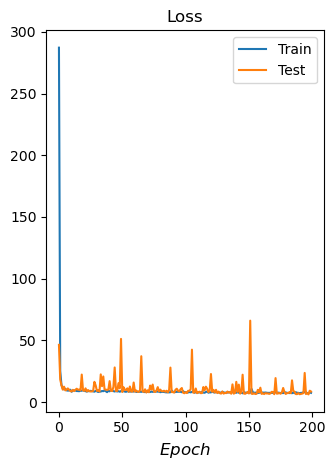

In [21]:
plt.subplot(1,2,1)
plt.plot(np.arange(epoch), Train_loss)
plt.plot(np.arange(epoch), Test_loss)
plt.xlabel("$Epoch$", size=12)
plt.title("Loss")
plt.legend(["Train", "Test"])
plt.tight_layout()

## Observation query
- When the `learning rate` is `0.0001`, both train and validation loss is exactly same curve.
- When the `learning rate` is `0.003`, there is a **sudden peek** for validation loss in between, even though train loss is not that high.

In [22]:
# Final
prediction = Model(X_Test) 
loss = loss_func(prediction, Y_Test)
print(f'Test MSE: {loss.item():.4f}')
print(f'Test MAE: {nn.L1Loss()(prediction, Y_Test).item():.4f}') # Mean absolute error

Test MSE: 8.5235
Test MAE: 2.0247
